# Simple Cell Segmentation with Single-Layered Perceptrons.
Nanyan "Rosalie" Zhu and Chen "Raphael" Liu.

This notebook belongs to this repository ["RnR-2018/BMEN4460-NB1-simple_cell_segmentation_with_a_single_layered_perceptron"](https://github.com/RnR-2018/BMEN4460-NB1-simple_cell_segmentation_with_a_single_layered_perceptron) and its parent repository ["RnR-2018/Deep-learning-with-PyTorch-and-GCP"](https://github.com/RnR-2018/Deep-learning-with-PyTorch-and-GCP).

#### Import the necessary packages.

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from matplotlib import pyplot as plt
from helper import rescaling, extract_patches_given_center, extract_all_patches, grouper

#### Set the random seed to ensure reproducibility.

In [2]:
torch.manual_seed(20200202)
np.random.seed(20200202)

#### Load a sample microscopy cell image.

In [3]:
cell_image_path = './data/sample_cell_img.tif'
cell_image = plt.imread(cell_image_path)

Max intensity: 4095 
Mean intensity: 248.141166556145 
Min intensity: 120


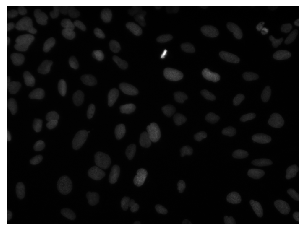

In [4]:
plt.imshow(cell_image, cmap = 'gray')
plt.axis('off');
print('Max intensity: %s \nMean intensity: %s \nMin intensity: %s' % (cell_image.max(), cell_image.mean(), cell_image.min()))

#### Adjust the image to satisfy our human eyes.
Also it is generally a good practise to rescale the image intensity to between 0 and 1 if these pixel values are going to be fed as inputs to a neural network.

Max intensity: 1.0 
Mean intensity: 0.09958455 
Min intensity: 0.0


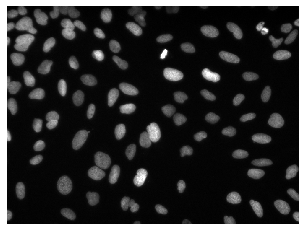

In [5]:
adjusted_cell_image = rescaling(np.float32(cell_image), lower_fraction = 0.001, upper_fraction = 0.999, out_range = (0, 1))
plt.imshow(adjusted_cell_image, cmap = 'gray')
plt.axis('off');
print('Max intensity: %s \nMean intensity: %s \nMin intensity: %s' % (adjusted_cell_image.max(), adjusted_cell_image.mean(), adjusted_cell_image.min()))

#### Note that this image is fairly easy to segment semantically. A simple thresholding will do the job.

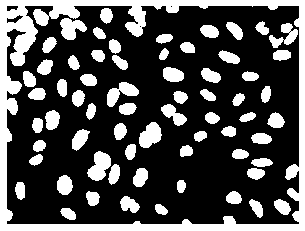

In [6]:
segmented_cell_image = np.int16(adjusted_cell_image > adjusted_cell_image.mean())
plt.imshow(segmented_cell_image, cmap = 'gray')
plt.axis('off');

#### Crop out a small patch with one single cell.

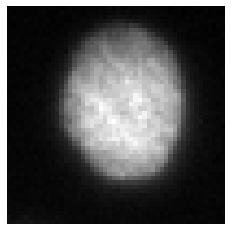

In [7]:
single_cell_image = adjusted_cell_image[0:50, 210:260]
segmented_single_cell_image = segmented_cell_image[0:50, 210:260]
plt.imshow(single_cell_image, cmap = 'gray')
plt.axis('off');

### Now we are going to use a single-layered perceptron to perform a semantic segmentation task.
Credit to [this Medium Post](https://medium.com/@tomgrek/building-your-first-neural-net-from-scratch-with-pytorch-56b0e9c84d54).

### Perceptron Candidate One! Single input single output.

This is probably the easiest neural network that you will ever see. It has the simplest structure and does the simplest function. It consists of 1 single layer, 1 single neuron/node, and the input/output pair each consists of 1 tensor of size 1 (aka, a scalar). It is supposed to map the pixel intensity in the cell image to the segmentation result for that pixel (whether or not the pixel belongs to a cell). It only uses the information on each specific pixel itself without looking at any of the surroundings or the global picture.

We used a sigmoid activation function because the task is a binary classification task.

- Input: A scalar representing the pixel intensity.
- Output: A scalar representing the likelihood for the corresponding input scalar to belong to a cell.

<img src="data/perceptron_single_input.PNG" width="1200" align="center"/>

#### Build our perceptron candidate 1.

In [8]:
class perceptron_candidate1(nn.Module):
    def __init__(self):
        super(perceptron_candidate1, self).__init__()
        self.fc1 = nn.Linear(1, 1, bias = True)
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

#### Define the loss function (for all our perceptrons).

In [9]:
def loss_function(out, label):
    return (label - out)**2

#### How do we train our percepron?

We can select the pixels from the cell image as the input, and the corresponding pixels in the segmented (by simple thresholding) as the ground truth to guide the training. We are going to use the pixels in the single-cell image that we just cropped out recently as our test set. **We need to make sure not to use the data in the test set to train our perceptron.**

In [10]:
# Crop out a certain region, that doesn't contain the test image, for training.
# adjust_cell_image_subset_for_training and segmented_cell_image_subset_for_training are both 100x100 images.
adjust_cell_image_subset_for_training = adjusted_cell_image[100:200, 0:100]
segmented_cell_image_subset_for_training = segmented_cell_image[100:200, 0:100]

# training_input and ground_truth are both of length 10000, as they are flattened versions of the corresponding 100x100 images.
training_input = adjust_cell_image_subset_for_training.flatten()
ground_truth = segmented_cell_image_subset_for_training.flatten()

# Reshape the horizonal arrays to vertical arrays. Now they become 10000x1 vectors.
training_input = np.reshape(training_input, (len(training_input), 1))
ground_truth = np.reshape(ground_truth, (len(ground_truth), 1))

# Stack them together
training_data = np.hstack((training_input, ground_truth))

In [11]:
# training_data consists of 2 columns: pixel value and segmentation ground truth (0 or 1).
training_data

array([[0.06533262, 0.        ],
       [0.05624202, 0.        ],
       [0.0595477 , 0.        ],
       ...,
       [0.02731738, 0.        ],
       [0.02401171, 0.        ],
       [0.02483813, 0.        ]], dtype=float32)

In [12]:
# Initialize our perceptron.
our_perceptron_candidate1 = perceptron_candidate1()
print(our_perceptron_candidate1)

# Define the optimizer.
candidate1_optimizer = optim.SGD(our_perceptron_candidate1.parameters(), lr = 0.01, momentum = 0.5)

# Train for 10 epochs.
for epoch in range(10):
    # Create a list to store the losses over every epoch.
    Epoch_loss_list = []
    # enumerate the training data.
    for iteration, training_input_GT_pair in enumerate(training_data):
        # isolate the training input and ground truth from the training data.
        training_input, GT = iter(training_input_GT_pair)
        # redefine the training input and ground truth and PyTorch tensors.
        training_input, GT = Variable(torch.FloatTensor([training_input])), \
                             Variable(torch.FloatTensor([GT]))
        # reset the gradient for the optimizer.
        candidate1_optimizer.zero_grad()
        # use the current model to predict the output from the input.
        outputs = our_perceptron_candidate1(training_input)
        # compute the loss (metric of goodness) between the prediction and the ground truth.
        loss = loss_function(outputs, GT)
        # backpropogate the gradient
        loss.backward()
        # update the weights using the gradient with the optimizer
        candidate1_optimizer.step()
        
        # append the current loss value to the loss list for this epoch.
        Epoch_loss_list.append(loss.data[0])

        # print the current loss every 1000 iterations.
        if (iteration % 1e4 == 0):
            print("Epoch {} - loss: {}".format(epoch, np.mean(Epoch_loss_list)))

perceptron_candidate1(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)
Epoch 0 - loss: 0.3928207755088806
Epoch 1 - loss: 0.14258016645908356
Epoch 2 - loss: 0.09995075315237045
Epoch 3 - loss: 0.08058656752109528
Epoch 4 - loss: 0.06964526325464249
Epoch 5 - loss: 0.06264661252498627
Epoch 6 - loss: 0.05779075622558594
Epoch 7 - loss: 0.05421843007206917
Epoch 8 - loss: 0.05147183686494827
Epoch 9 - loss: 0.04928478226065636


In [13]:
print("What's the probability for a cell image pixel with value 0.1 to belong to a cell? ", \
      our_perceptron_candidate1(Variable(torch.Tensor([[[0.1]]]))).cpu().detach().numpy()[0][0][0])

print("What's the probability for a cell image pixel with value 0.2 to belong to a cell? ", \
      our_perceptron_candidate1(Variable(torch.Tensor([[[0.2]]]))).cpu().detach().numpy()[0][0][0])

print("What's the probability for a cell image pixel with value 0.5 to belong to a cell? ", \
      our_perceptron_candidate1(Variable(torch.Tensor([[[0.5]]]))).cpu().detach().numpy()[0][0][0])

What's the probability for a cell image pixel with value 0.1 to belong to a cell?  0.31709003
What's the probability for a cell image pixel with value 0.2 to belong to a cell?  0.66944
What's the probability for a cell image pixel with value 0.5 to belong to a cell?  0.99408394


#### Let's try it out on our test image (the single-cell cropped-out image).

In [14]:
candidate1_predicted_segmentation = np.zeros(single_cell_image.shape)

for current_row in range(candidate1_predicted_segmentation.shape[0]):
    for current_column in range(candidate1_predicted_segmentation.shape[1]):
        current_pixel_value = single_cell_image[current_row, current_column]
        candidate1_predicted_segmentation[current_row, current_column] = \
        our_perceptron_candidate1(Variable(torch.Tensor([[[current_pixel_value]]]))).cpu().detach().numpy()[0][0][0]
        
# Although we used a sigmoid activation function, the output is still not going to be exactly 0 or 1. We need to binarize the output anyway.
candidate1_predicted_segmentation = np.int16(candidate1_predicted_segmentation > 0.5)

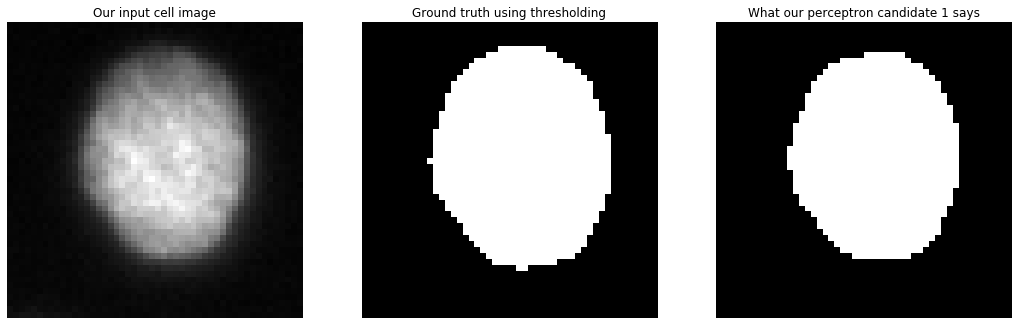

In [15]:
plt.rcParams['figure.figsize'] = [18, 10]

plt.subplot(1, 3, 1)
plt.imshow(single_cell_image, cmap = 'gray'); plt.axis('off'); plt.title('Our input cell image');
plt.subplot(1, 3, 2)
plt.imshow(segmented_single_cell_image, cmap = 'gray'); plt.axis('off'); plt.title('Ground truth using thresholding');
plt.subplot(1, 3, 3)
plt.imshow(candidate1_predicted_segmentation, cmap = 'gray'); plt.axis('off'); plt.title('What our perceptron candidate 1 says');

### Perceptron Candidate Two! Multi input single output. (Training a convolutional kernel.)

*Anything beyond this point is not necessary for this task, because the image-to-segmentation mapping is a simple monotonic relationship that can be even achieved by a simple thresholding. However, this might be a good practice in case you face slightly more complicated cases in the future. Well of course you can go after more powerful tools then and give up on perceptrons altogether...*

Now we have upgraded our perceptron. Same as before, it consists of 1 single layer, 1 single neuron/node, and the output consists of 1 tensor of size 1 (aka, a scalar). But the difference is that for this one it takes in multiple inputs. It still maps the pixel intensity in the cell image to the segmentation result for that pixel (whether or not the pixel belongs to a cell), but this time it starts taking the surrounding pixels into consideration.

- Input: Conceptually, it is a 3$\times$3 tensor/matrix representing the pixel intensity in a 3$\times$3 region. In reality, this tensor/matrix needs to be flattened into a 9$\times$1 vector to be fed into the perceptron as the input.
- Output: A scalar representing the likelihood for the corresponding center of the 3$\times$3 region to belong to a cell.

The idea of looking at a 3$\times$3 neighborhood of the pixel under inspection is somewhat similar to the notion of convolution. **What we are doing here is effectively training a single convolutional feature-extraction kernel.** You will probably get a better understanding on what we are doing and why we are doing this when you study convolutional neural networks (CNN) in the future lectures.

<img src="data/perceptron_multi_input.PNG" width="1200" align="center"/>

#### Build our perceptron candidate 2.

In [16]:
class perceptron_candidate2(nn.Module):
    def __init__(self):
        super(perceptron_candidate2, self).__init__()
        self.fc1 = nn.Linear(9, 1, bias = False)
        self.fc2 = nn.Linear(1, 1, bias = True)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [17]:
# Crop out a certain region, that doesn't contain the test image, for training.
adjust_cell_image_subset_for_training = adjusted_cell_image[100:200, 0:100]
segmented_cell_image_subset_for_training = segmented_cell_image[100:200, 0:100]

# training_patches_3x3_matrix is a 100x100x3x3 tensor. training_patches_3x3_matrix[x, y, :, :] is a 3x3 matrix
# who corresponds to the 3x3 neighborhood of the pixel adjust_cell_image_subset_for_training[x, y].
training_patches_3x3_matrix = extract_all_patches(adjust_cell_image_subset_for_training, patch_x = 3, patch_y = 3)

# training_patches_3x3_array is a 10000x3x3 tensor. training_patches_3x3_matrix[index, :, :] is a 3x3 matrix
# who corresponds to the 3x3 neighborhood of the pixel adjust_cell_image_subset_for_training.flatten()[index].
training_patches_3x3_array = training_patches_3x3_matrix.reshape(-1, training_patches_3x3_matrix.shape[-2], training_patches_3x3_matrix.shape[-1])

ground_truth = segmented_cell_image_subset_for_training.flatten()

# Reshape the horizonal arrays to vertical arrays.
# training_input now becomes a 10000x9 array. Each 1 of the 10000 element is a flattened vector of length 9.
# ground_truth has a shape 10000x1.
training_input = np.reshape(training_patches_3x3_array, (len(training_patches_3x3_array), 9))
ground_truth = np.reshape(ground_truth, (len(ground_truth), 1))

# Stack the training input and the ground truth together.
# training_data is now a 10000x10 tensor, with the first 9 columns being inputs and the last column being the ground truth.
training_data = np.hstack((training_input, ground_truth))

In [18]:
# training_data consists of 9 columns: 3x3 neighborhood of each image pixel, and segmentation ground truth for that image pixel (0 or 1).
training_data

array([[0.02483813, 0.18433684, 0.17194058, ..., 0.05210993, 0.04301933,
        0.        ],
       [0.18433684, 0.17194058, 0.1959067 , ..., 0.04301933, 0.04467217,
        0.        ],
       [0.17194058, 0.1959067 , 0.25623524, ..., 0.04467217, 0.03144947,
        0.        ],
       ...,
       [0.02979664, 0.01987962, 0.03144947, ..., 0.6157272 , 0.5950667 ,
        0.        ],
       [0.01987962, 0.03144947, 0.0281438 , ..., 0.5950667 , 0.552093  ,
        0.        ],
       [0.03144947, 0.0281438 , 0.24135971, ..., 0.552093  , 0.06533262,
        0.        ]], dtype=float32)

In [19]:
# Initialize our perceptron.
our_perceptron_candidate2 = perceptron_candidate2()
print(our_perceptron_candidate2)

# Define the optimizer.
optimizer = optim.SGD(our_perceptron_candidate2.parameters(), lr = 0.001, momentum = 0.5)

# Train for 5 epochs.
for epoch in range(5):
    # Create a list to store the losses over every epoch.
    Epoch_loss_list = []
    # enumerate the training data.
    for iteration, training_input_GT_pair in enumerate(training_data):
        # isolate the training input and ground truth from the training data.
        training_input, GT = grouper(9, iter(training_input_GT_pair))
        # redefine the training input and ground truth and PyTorch tensors.
        training_input, GT = Variable(torch.FloatTensor(training_input)), \
                             Variable(torch.FloatTensor(GT))
        # reset the gradient for the optimizer.
        optimizer.zero_grad()
        # use the current model to predict the output from the input.
        outputs = our_perceptron_candidate2(training_input)
        # compute the loss (metric of goodness) between the prediction and the ground truth.
        loss = loss_function(outputs, GT)
        # backpropogate the gradient
        loss.backward()
        # update the weights using the gradient with the optimizer
        optimizer.step()

        # append the current loss value to the loss list for this epoch.
        Epoch_loss_list.append(loss.data[0])
        
        # print the current loss every 1000 iterations.
        if (iteration % 3e3 == 0):
#            print(training_input)
            print("Epoch {} - loss: {}".format(epoch, np.mean(Epoch_loss_list)))

perceptron_candidate2(
  (fc1): Linear(in_features=9, out_features=1, bias=False)
  (fc2): Linear(in_features=1, out_features=1, bias=True)
)
Epoch 0 - loss: 0.18687285482883453
Epoch 0 - loss: 0.1960943043231964
Epoch 0 - loss: 0.17227518558502197
Epoch 0 - loss: 0.1500333845615387
Epoch 1 - loss: 0.43374332785606384
Epoch 1 - loss: 0.08683376014232635
Epoch 1 - loss: 0.07898493111133575
Epoch 1 - loss: 0.07292558997869492
Epoch 2 - loss: 0.4911710321903229
Epoch 2 - loss: 0.058062635362148285
Epoch 2 - loss: 0.05312006175518036
Epoch 2 - loss: 0.050607822835445404
Epoch 3 - loss: 0.5444408655166626
Epoch 3 - loss: 0.046687252819538116
Epoch 3 - loss: 0.04240851104259491
Epoch 3 - loss: 0.040953390300273895
Epoch 4 - loss: 0.5915493965148926
Epoch 4 - loss: 0.04062025994062424
Epoch 4 - loss: 0.03659557178616524
Epoch 4 - loss: 0.03556350618600845


#### Let's try it out on our test image (the single-cell cropped-out image).

In [20]:
candidate2_predicted_segmentation = np.zeros(single_cell_image.shape)

for current_row in range(candidate2_predicted_segmentation.shape[0]):
    for current_column in range(candidate2_predicted_segmentation.shape[1]):
        current_pixel_neighborhood = extract_patches_given_center(single_cell_image, current_row, current_column, patch_x = 3, patch_y = 3)
        current_pixel_neighborhood = np.reshape(current_pixel_neighborhood, (1, 9))
        candidate2_predicted_segmentation[current_row, current_column] = \
        our_perceptron_candidate2(Variable(torch.tensor(current_pixel_neighborhood))).cpu().detach().numpy()[0][0]
        
# Although we used a sigmoid activation function, the output is still not going to be exactly 0 or 1. We need to binarize the output anyway.
candidate2_predicted_segmentation = np.int16(candidate2_predicted_segmentation > 0.5)

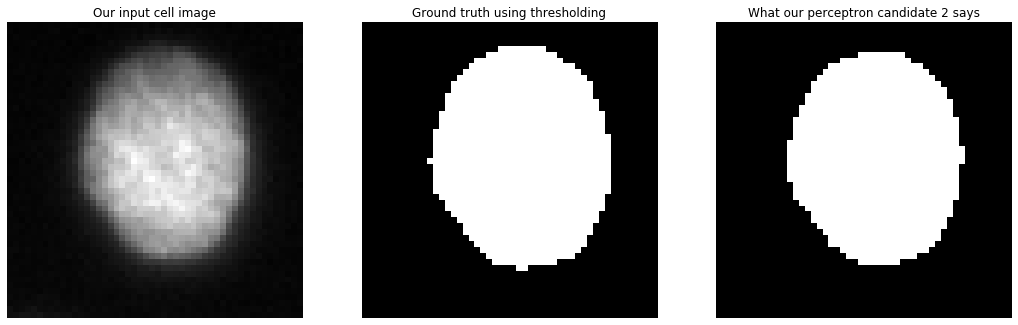

In [21]:
plt.rcParams['figure.figsize'] = [18, 10]

plt.subplot(1, 3, 1)
plt.imshow(single_cell_image, cmap = 'gray'); plt.axis('off'); plt.title('Our input cell image');
plt.subplot(1, 3, 2)
plt.imshow(segmented_single_cell_image, cmap = 'gray'); plt.axis('off'); plt.title('Ground truth using thresholding');
plt.subplot(1, 3, 3)
plt.imshow(candidate2_predicted_segmentation, cmap = 'gray'); plt.axis('off'); plt.title('What our perceptron candidate 2 says');

### Perceptron Candidate Three! The simplest CNN perceptron. (Actually using the convolutional operation.)

This time we are re-implementing the idea behind perceptron candidate 2, except that we are going to do it in a more elegant and more succinct manner. Just as what we have said before, perceptron candidate 2 basically re-invented the concept of a convolutional kernel. Now we will see how people will build a convolutional neural network, or in our case a perceptron with 1 single layer and 1 single convolutional kernel, in real life.

- Input: A 3$\times$3 tensor/matrix representing the pixel intensity in a 3$\times$3 region. This 3$\times$3 region will remain this shape when fed into the perceptron.
- Output: A scalar representing the likelihood for the corresponding center of the 3$\times$3 region to belong to a cell.

This is a 3$\times$3 -> 1$\times$1 mapping.

<img src="data/perceptron_CNN.PNG" width="1200" align="center"/>

In [22]:
input_channel = 1; output_channel = 1

class perceptron_candidate3(nn.Module):
    def __init__(self):
        super(perceptron_candidate3, self).__init__()
        self.conv = nn.Conv2d(input_channel, output_channel, kernel_size=3, stride = 1, padding = 1)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 1)
    def forward(self, x):
        x = self.conv(x)
        x = self.maxpool(x)
        x = torch.sigmoid(x)
        return x

In [23]:
# Crop out a certain region, that doesn't contain the test image, for training.
adjust_cell_image_subset_for_training = adjusted_cell_image[100:200, 0:100]
segmented_cell_image_subset_for_training = segmented_cell_image[100:200, 0:100]

# training_patches_3x3_matrix is a 100x100x3x3 tensor. training_patches_3x3_matrix[x, y, :, :] is a 3x3 matrix
# who corresponds to the 3x3 neighborhood of the pixel adjust_cell_image_subset_for_training[x, y].
training_patches_3x3_matrix = extract_all_patches(adjust_cell_image_subset_for_training, patch_x = 3, patch_y = 3)

# training_patches_3x3_array is a 10000x3x3 tensor. training_patches_3x3_matrix[index, :, :] is a 3x3 matrix
# who corresponds to the 3x3 neighborhood of the pixel adjust_cell_image_subset_for_training.flatten()[index].
training_patches_3x3_array = training_patches_3x3_matrix.reshape(-1, training_patches_3x3_matrix.shape[-2], training_patches_3x3_matrix.shape[-1])

ground_truth = segmented_cell_image_subset_for_training.flatten()

# Reshape the horizonal arrays to vertical arrays.
# training_input now becomes a 10000x9 array. Each 1 of the 10000 element is a flattened vector of length 9.
# ground_truth has a shape 10000x1.
#training_input = np.reshape(training_patches_3x3_array, (len(training_patches_3x3_array), 9))
training_input = training_patches_3x3_array
ground_truth = np.reshape(ground_truth, (len(ground_truth), 1))

In [24]:
# Initialize our perceptron.
our_perceptron_candidate3 = perceptron_candidate3()
print(our_perceptron_candidate3)

# Define the optimizer.
optimizer = optim.SGD(our_perceptron_candidate3.parameters(), lr = 0.01, momentum = 0.5)

# Train for 5 epochs.
for epoch in range(5):
    # Create a list to store the losses over every epoch.
    Epoch_loss_list = []
    # "zip", unlike when we use "iter" or "grouper", cannot be re-used and thus we need to put that inside the loop.
    training_data = zip(training_input, ground_truth)
    # enumerate the training data.
    for iteration, training_input_GT_pair in enumerate(training_data):
        # isolate the training input and ground truth from the training data.
        our_input, our_GT = iter(training_input_GT_pair)
        # redefine the training input and ground truth and PyTorch tensors.
        our_input, our_GT = Variable(torch.FloatTensor(our_input)), \
                             Variable(torch.FloatTensor(our_GT))
        
        # For the CNN, we need to reshape the input to [num_batch, num_channel, x_dimension, y_dimension]
        our_input = our_input[np.newaxis, np.newaxis, :, :]
        # reset the gradient for the optimizer.
        optimizer.zero_grad()
        # use the current model to predict the output from the input.
        outputs = our_perceptron_candidate3(our_input)
        # compute the loss (metric of goodness) between the prediction and the ground truth.
        loss = loss_function(outputs, our_GT)
        # backpropogate the gradient
        loss.backward()
        # update the weights using the gradient with the optimizer
        optimizer.step()

        # append the current loss value to the loss list for this epoch.
        Epoch_loss_list.append(loss.data[0])
        
        # print the current loss every 1000 iterations.
        if (iteration % 3e3 == 0):
            print("Epoch {} - loss: {}".format(epoch, np.mean(Epoch_loss_list)))

perceptron_candidate3(
  (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
)
Epoch 0 - loss: 0.30111783742904663
Epoch 0 - loss: 0.1483122706413269
Epoch 0 - loss: 0.1103004738688469
Epoch 0 - loss: 0.0910266861319542
Epoch 1 - loss: 0.44225919246673584
Epoch 1 - loss: 0.045957885682582855
Epoch 1 - loss: 0.04098516330122948
Epoch 1 - loss: 0.03990384563803673
Epoch 2 - loss: 0.5059212446212769
Epoch 2 - loss: 0.037163447588682175
Epoch 2 - loss: 0.032997436821460724
Epoch 2 - loss: 0.032919805496931076
Epoch 3 - loss: 0.5580415725708008
Epoch 3 - loss: 0.03327879309654236
Epoch 3 - loss: 0.029407305642962456
Epoch 3 - loss: 0.029606349766254425
Epoch 4 - loss: 0.6007249355316162
Epoch 4 - loss: 0.030984608456492424
Epoch 4 - loss: 0.027280451729893684
Epoch 4 - loss: 0.02757955715060234


#### Let's try it out on our test image (the single-cell cropped-out image).

In [25]:
candidate3_predicted_segmentation = np.zeros(single_cell_image.shape)

for current_row in range(candidate3_predicted_segmentation.shape[0]):
    for current_column in range(candidate3_predicted_segmentation.shape[1]):
        current_pixel_neighborhood = extract_patches_given_center(single_cell_image, current_row, current_column, patch_x = 3, patch_y = 3)
        current_pixel_neighborhood = np.reshape(current_pixel_neighborhood, (1, 1, 3, 3))
        candidate3_predicted_segmentation[current_row, current_column] = \
        our_perceptron_candidate3(Variable(torch.tensor(current_pixel_neighborhood))).cpu().detach().numpy()[0][0]
        
# Although we used a sigmoid activation function, the output is still not going to be exactly 0 or 1. We need to binarize the output anyway.
candidate3_predicted_segmentation = np.int16(candidate3_predicted_segmentation > 0.5)

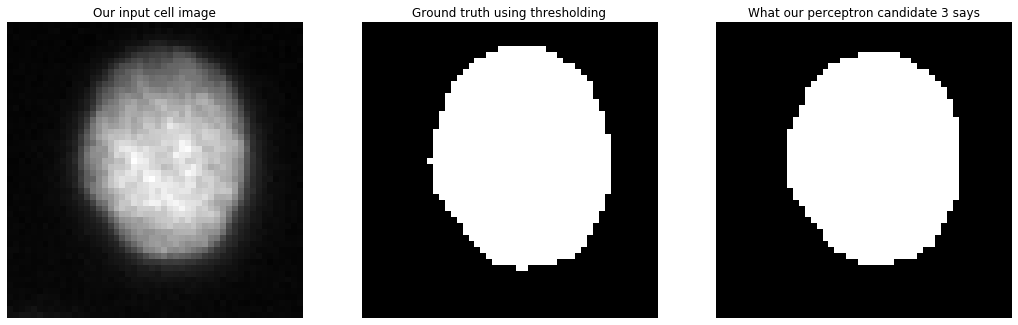

In [26]:
plt.rcParams['figure.figsize'] = [18, 10]

plt.subplot(1, 3, 1)
plt.imshow(single_cell_image, cmap = 'gray'); plt.axis('off'); plt.title('Our input cell image');
plt.subplot(1, 3, 2)
plt.imshow(segmented_single_cell_image, cmap = 'gray'); plt.axis('off'); plt.title('Ground truth using thresholding');
plt.subplot(1, 3, 3)
plt.imshow(candidate3_predicted_segmentation, cmap = 'gray'); plt.axis('off'); plt.title('What our perceptron candidate 3 says');

## Some closing remarks

Of course, in a more comprehensive case, when we use a convolutional neural network (CNN), we wouldn't chop up the images into small 3$\times$3 patches for training and evaluation. The common practice is to train with images of the size that you would expect your test images to have. For example, if our desired test image is of dimension 50$\times$50, we would most likely build a CNN such that:

1) it can accomodate the 50$\times$50 input image, and

2) it generates the segmentation mask of dimension 50$\times$50.

We are quite sure you will soon see how real-life CNNs are implemented, and this tutorial is just to give you a bit of the taste as well as shed some lights on the philosophies behind the essential concepts of perceptrons and CNNs.